# Anime Score Predictor using Linear Regression Models (Without Popularity)

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE

## 2. Loading Data

In [50]:
df = pd.read_csv('mal-anime.csv')
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


In [51]:
df.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1'],
      dtype='object')

## 3. Data Preprocessing

In [52]:
genres = df['Genres']
split_genres = genres.str.split(',').apply(lambda x: [i.strip() for i in x])

# Flatten the list of genres and find the unique genres
unique_genres = pd.unique([item for sublist in split_genres for item in sublist])
print(unique_genres)

['Action' 'Adventure' 'Comedy' 'Drama' 'Sci-Fi' 'Space' 'Mystery'
 'Shounen' 'Police' 'Supernatural' 'Magic' 'Fantasy' 'Sports' 'Josei'
 'Romance' 'Slice of Life' 'Cars' 'Seinen' 'Horror' 'Psychological'
 'Thriller' 'Super Power' 'Martial Arts' 'School' 'Ecchi' 'Vampire'
 'Military' 'Historical' 'Dementia' 'Mecha' 'Demons' 'Samurai' 'Game'
 'Shoujo' 'Harem' 'Music' 'Shoujo Ai' 'Shounen Ai' 'Kids' 'Hentai'
 'Parody' 'Yuri' 'Yaoi' 'Unknown']


In [53]:
for genre in unique_genres:
    df[genre] = split_genres.apply(lambda x: 1 if genre in x else 0)
df.rename(columns={'Unknown': 'Unknown_Genre'}, inplace=True)
df.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1', 'Action',
       'Adventure', 'Comedy', 'Drama', 'Sci-Fi', 'Space', 'Mystery', 'Shounen',
       'Police', 'Supernatural', 'Magic', 'Fantasy', 'Sports', 'Josei',
       'Romance', 'Slice of Life', 'Cars', 'Seinen', 'Horror', 'Psychological',
       'Thriller', 'Super Power', 'Martial Arts', 'School', 'Ecchi', 'Vampire',
       'Military', 'Historical', 'Dementia', 'Mecha', 'Demons', 'Samurai',
       'Game', 'Shoujo', 'Harem', 'Music', 'Shoujo Ai', 'Shounen Ai', 'Kids',
       'Hentai', 'Parody', 'Yuri', 'Yaoi', 'Unknown_Genre'],
      dtype='objec

In [54]:
print(len(df[df["Episodes"] == "Unknown"]["Name"]))
print(df[df["Episodes"] == "Unknown"]["Name"].head(10))
# Drop all rows with 'Unknown' in the 'Episodes' column 
df = df[df['Episodes'] != 'Unknown']
print(len(df[df["Score"] == "Unknown"]["Name"]))
print(df[df["Score"] == "Unknown"]["Name"].head(10))
# Drop all rows with 'Unknown' in the 'Score', 'Ranked', and 'Aired' column 
df = df[df['Score'] != 'Unknown']
# df = df[df['Ranked'] != 'Unknown']
df = df[df['Aired'] != 'Unknown']

516
11                     One Piece
211              Detective Conan
871             Crayon Shin-chan
1093            Nintama Rantarou
1787          Sore Ike! Anpanman
2203                   Sazae-san
3650                   Ojarumaru
4477    Chibi Maruko-chan (1995)
5040                    Knyacki!
5334                   Hanakappa
Name: Name, dtype: object
4730
1404                                     Obake no Q-tarou
1504                                      PostPet Momobin
1578                           Shibawanko no Wa no Kokoro
1699                              Silk Road Shounen Yuuto
1893    Hengen Taima Yakou Karura Mau! Sendai Kokeshi ...
1990    Kouchuu Ouja Mushiking Super Battle Movie: Yam...
2165                                  Touma Kishinden Oni
2422            Dorami-chan: Wow, The Kid Gang of Bandits
2425                   Dorami-chan: Hello Kyouryuu Kids!!
2428                        Dorami-chan: A Blue Straw Hat
Name: Name, dtype: object


In [55]:
smallest_years = []

for aired in df['Aired']:
    # Extract all years using regular expressions
    years = re.findall('(\d{4})', aired)
    
    # Convert the years to integers
    years = [int(year) for year in years] 
    if years:
        smallest_years.append(min(years))
    else:
        smallest_years.append(np.nan)

# Replace the 'Aired' column with the smallest years
df['Aired'] = smallest_years
df['Aired'].head()

0    1998
1    2001
2    1998
3    2002
4    2004
Name: Aired, dtype: int64

In [56]:
def convert_to_seconds(duration):
    time_units = duration.split()
    seconds = 0
    for i in range(0, len(time_units), 2):
        if i+1 < len(time_units):
            if 'h' in time_units[i+1]:
                seconds += int(time_units[i]) * 3600
            elif 'm' in time_units[i+1]:
                seconds += int(time_units[i]) * 60
            elif 's' in time_units[i+1]:
                seconds += int(time_units[i])
    return seconds

df['Duration'] = df['Duration'].apply(convert_to_seconds)
df['Duration'].head()

0    1440
1    6900
2    1440
3    1500
4    1380
Name: Duration, dtype: int64

In [57]:
# Standardizing data types
df['Score'] = df['Score'].astype(float)
df['Episodes'] = df['Episodes'].astype(np.int64)
df['Popularity'] = df['Popularity'].astype(np.int64)
# df['Members'] = df['Members'].astype(np.int64)
# df['Completed'] = df['Completed'].astype(np.int64)
# df['Dropped'] = df['Dropped'].astype(np.int64)
# df['Ranked'] = df['Ranked'].astype(float)
# df['Plan to Watch'] = df['Plan to Watch'].astype(np.int64)

## 4. Data Visualization

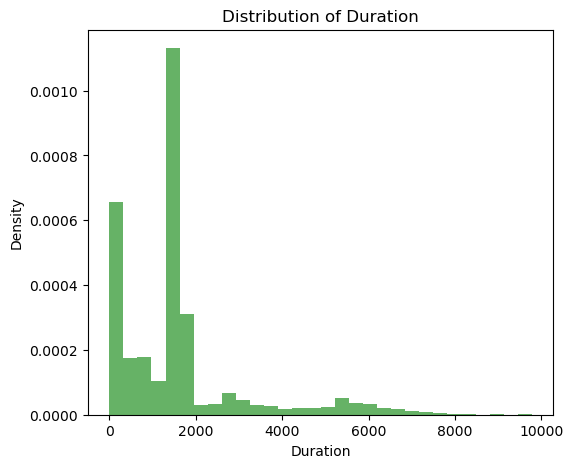

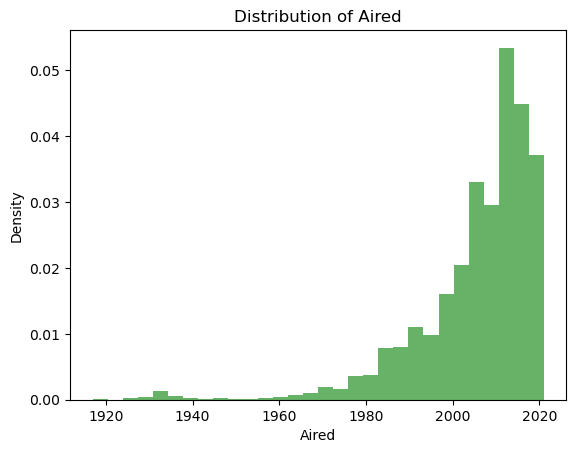

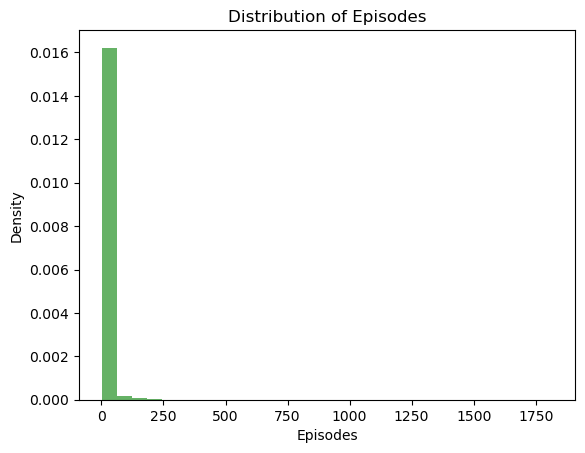

In [58]:
# Drop NaN values from 'Duration' column
duration = df['Duration'].dropna()
aired = df['Aired'].dropna()
episodes = df['Episodes'].dropna()

plt.figure(figsize=(6, 5))

# Create a histogram with a density curve
plt.hist(duration, bins=30, density=True, alpha=0.6, color='g')

plt.title('Distribution of Duration')
plt.xlabel('Duration')
plt.ylabel('Density')

plt.show()

# Repeat for 'Aired' and 'Episodes'
plt.hist(aired, bins=30, density=True, alpha=0.6, color='g')
plt.title('Distribution of Aired')
plt.xlabel('Aired')
plt.ylabel('Density')
plt.show()

plt.hist(episodes, bins=30, density=True, alpha=0.6, color='g')
plt.title('Distribution of Episodes')
plt.xlabel('Episodes')
plt.ylabel('Density')
plt.show()

Dropping the columns that are not required for the analysis.

In [59]:
columns_to_drop = ['Type', 'Rating', 'Genres', 'Score-1', 'Score-2', 'Score-3', 'Score-4', 'Score-5', 'Score-6', 'Score-7', 'Score-8', 'Score-9', 'Score-10', 
                   'Ranked', 'Favorites', 'Members' , 'Watching' , 'On-Hold' , 'Completed', 'Dropped', 'Plan to Watch', 
                   'MAL_ID', 'Name', 'English name' , 'Japanese name' , 'Premiered' , 'Producers', 'Licensors', 
                   'Source', 'Studios', 
                   'Unknown_Genre','Hentai', 'Yuri', 'Yaoi', 'Popularity']

df = df.drop(columns_to_drop, axis=1)
df.columns

Index(['Score', 'Episodes', 'Aired', 'Duration', 'Action', 'Adventure',
       'Comedy', 'Drama', 'Sci-Fi', 'Space', 'Mystery', 'Shounen', 'Police',
       'Supernatural', 'Magic', 'Fantasy', 'Sports', 'Josei', 'Romance',
       'Slice of Life', 'Cars', 'Seinen', 'Horror', 'Psychological',
       'Thriller', 'Super Power', 'Martial Arts', 'School', 'Ecchi', 'Vampire',
       'Military', 'Historical', 'Dementia', 'Mecha', 'Demons', 'Samurai',
       'Game', 'Shoujo', 'Harem', 'Music', 'Shoujo Ai', 'Shounen Ai', 'Kids',
       'Parody'],
      dtype='object')

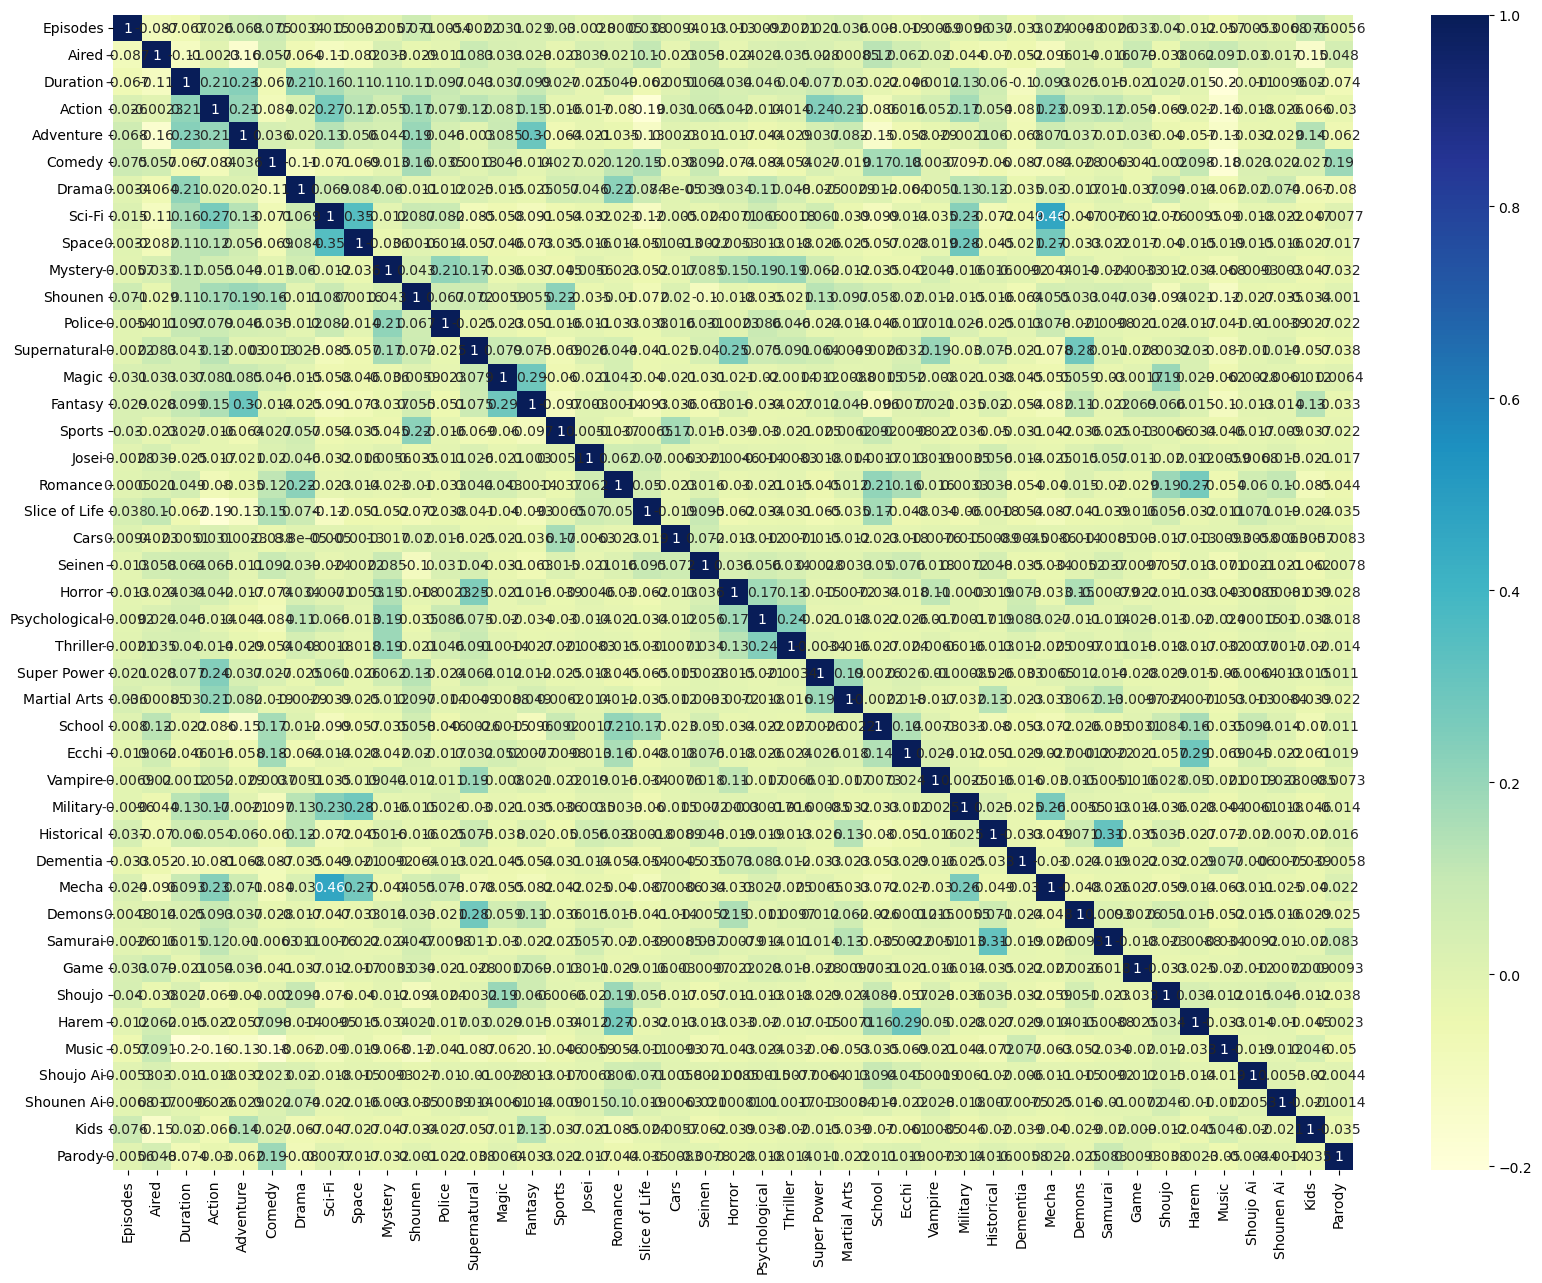

In [60]:

scaler = StandardScaler()

# Fit the scaler to the 'Aired', 'Completed', 'Dropped', and 'Favorites' columns and transform them
df[['Episodes', 'Duration', 'Aired']] = scaler.fit_transform(df[['Episodes', 'Duration', 'Aired']])
X = df.drop('Score', axis=1)
y = df['Score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

plt.figure(figsize=(20,15))
sns.heatmap(X.corr(), annot=True, cmap='YlGnBu')
plt.show()

# OLS Regression without Popularity and without RFE

In [61]:
def calculate_vif(X, index):
    mask = np.arange(X.shape[1]) != index
    model = LinearRegression()
    model.fit(X.iloc[:, mask], X.iloc[:, index])
    r_squared = model.score(X.iloc[:, mask], X.iloc[:, index])
    return 1 / (1 - r_squared)

vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns

vif_data["VIF"] = [calculate_vif(X_train, i) for i in range(X_train.shape[1])]

print(vif_data)

          feature       VIF
0        Episodes  1.049225
1           Aired  1.147352
2        Duration  1.251329
3          Action  1.450438
4       Adventure  1.323399
5          Comedy  1.288264
6           Drama  1.201430
7          Sci-Fi  1.507713
8           Space  1.240274
9         Mystery  1.185463
10        Shounen  1.262373
11         Police  1.095090
12   Supernatural  1.266733
13          Magic  1.162620
14        Fantasy  1.302713
15         Sports  1.165273
16          Josei  1.027343
17        Romance  1.272092
18  Slice of Life  1.166399
19           Cars  1.043266
20         Seinen  1.099392
21         Horror  1.151258
22  Psychological  1.138226
23       Thriller  1.099908
24    Super Power  1.128165
25   Martial Arts  1.128880
26         School  1.190888
27          Ecchi  1.177790
28        Vampire  1.071495
29       Military  1.192384
30     Historical  1.203042
31       Dementia  1.058404
32          Mecha  1.388433
33         Demons  1.108988
34        Samurai  1

In [62]:
model = LinearRegression()

scores = cross_val_score(model, X_train, y_train, cv=5)

print(f"Cross-validation scores: {scores}")

print(f"Mean cross-validation score: {scores.mean()}")

print(f"Standard Deviation of cross-validation score: {scores.std()}")

Cross-validation scores: [0.39649803 0.39377049 0.33916345 0.38039292 0.39444457]
Mean cross-validation score: 0.3808538918004286
Standard Deviation of cross-validation score: 0.02160828539218978


Text(0, 0.5, 'Score')

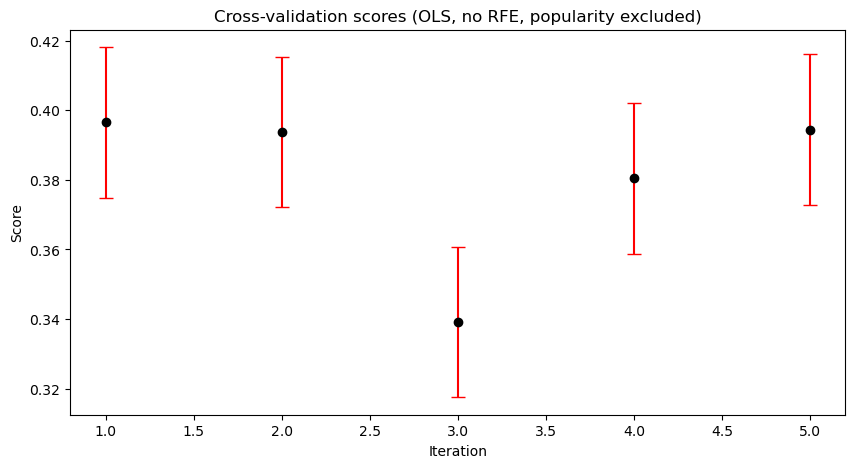

In [63]:
plt.figure(figsize=(10, 5))
plt.errorbar(range(1, 6), scores, yerr=scores.std(), fmt='o', color='black', ecolor='red', capsize=5)
plt.title('Cross-validation scores (OLS, no RFE, popularity excluded)')
plt.xlabel('Iteration')
plt.ylabel('Score')

In [64]:

model.fit(X_train, y_train)
# for feature, coef in zip(X_train.columns, model.coef_):
#     print(f"{feature}: {coef}")

y_pred = model.predict(X_test)

print(f"R-squared Score: {r2_score(y_test, y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred)}")

R-squared Score: 0.3863782921997164
Mean Squared Error: 0.47188179764445043
Mean Absolute Error: 0.5376218668234926


# OLS Regression with no Popularity and RFE

In [65]:
model = LinearRegression()

rfe = RFE(estimator=model, n_features_to_select=10)

X_train_rfe = rfe.fit_transform(X_train, y_train)

scores = cross_val_score(model, X_train, y_train, cv=5)

print(f"Cross-validation scores: {scores}")

print(f"Mean cross-validation score: {scores.mean()}")

print(f"Standard Deviation of cross-validation score: {scores.std()}")

model.fit(X_train_rfe, y_train)

selected_features = pd.Series(rfe.support_, index = X_train.columns)
print(selected_features[selected_features==True].index)

X_test_rfe = rfe.transform(X_test)
y_pred = model.predict(X_test_rfe)

print(f"R-squared Score: {r2_score(y_test, y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred)}")

Cross-validation scores: [0.39649803 0.39377049 0.33916345 0.38039292 0.39444457]
Mean cross-validation score: 0.3808538918004286
Standard Deviation of cross-validation score: 0.02160828539218978
Index(['Drama', 'Mystery', 'Shounen', 'Supernatural', 'Seinen', 'Horror',
       'Thriller', 'School', 'Military', 'Dementia'],
      dtype='object')
R-squared Score: 0.2130986617628433
Mean Squared Error: 0.6051357266797164
Mean Absolute Error: 0.6189253337517432


Text(0, 0.5, 'Score')

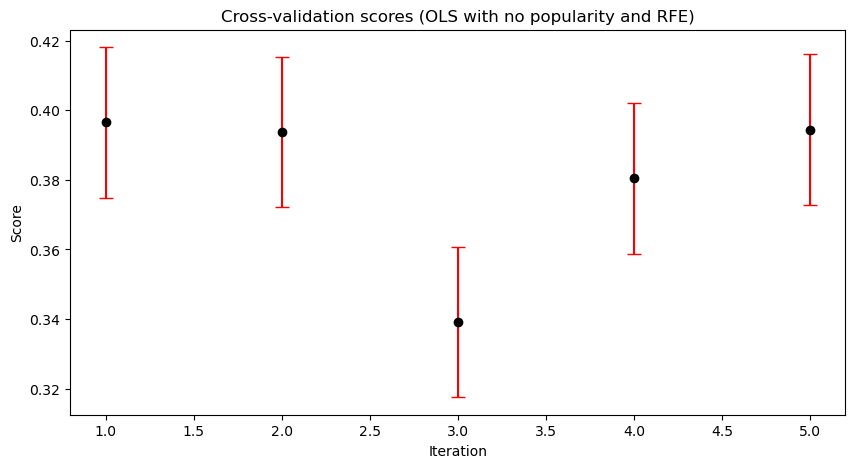

In [66]:
plt.figure(figsize=(10, 5))
plt.errorbar(range(1, 6), scores, yerr=scores.std(), fmt='o', color='black', ecolor='red', capsize=5)
plt.title('Cross-validation scores (OLS with no popularity and RFE)')
plt.xlabel('Iteration')
plt.ylabel('Score')

# Ridge Regression with Popularity and without RFE

In [67]:
def calculate_vif(X, index):
    mask = np.arange(X.shape[1]) != index
    model = Ridge(alpha=1.0)
    model.fit(X.iloc[:, mask], X.iloc[:, index])
    r_squared = model.score(X.iloc[:, mask], X.iloc[:, index])

    # Calculate and return the VIF
    return 1 / (1 - r_squared)
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns

# Calculate VIF for each feature
vif_data["VIF"] = [calculate_vif(X_train, i) for i in range(X_train.shape[1])]

print(vif_data)

          feature       VIF
0        Episodes  1.049225
1           Aired  1.147351
2        Duration  1.251328
3          Action  1.450434
4       Adventure  1.323398
5          Comedy  1.288261
6           Drama  1.201428
7          Sci-Fi  1.507711
8           Space  1.240274
9         Mystery  1.185458
10        Shounen  1.262370
11         Police  1.095089
12   Supernatural  1.266727
13          Magic  1.162620
14        Fantasy  1.302712
15         Sports  1.165261
16          Josei  1.027343
17        Romance  1.272087
18  Slice of Life  1.166397
19           Cars  1.043266
20         Seinen  1.099389
21         Horror  1.151256
22  Psychological  1.138221
23       Thriller  1.099907
24    Super Power  1.128164
25   Martial Arts  1.128879
26         School  1.190885
27          Ecchi  1.177788
28        Vampire  1.071494
29       Military  1.192383
30     Historical  1.203035
31       Dementia  1.058403
32          Mecha  1.388432
33         Demons  1.108987
34        Samurai  1

In [68]:
model = Ridge(alpha=1.0)

scores = cross_val_score(model, X_train, y_train, cv=5)

print(f"Cross-validation scores: {scores}")

print(f"Mean cross-validation score: {scores.mean()}")

print(f"Standard Deviation of cross-validation score: {scores.std()}")

Cross-validation scores: [0.39650672 0.39381732 0.33912734 0.3804766  0.39450336]
Mean cross-validation score: 0.3808862664954177
Standard Deviation of cross-validation score: 0.02163613626265188


In [69]:
model.fit(X_train, y_train)

# for feature, coef in zip(X_train.columns, model.coef_):
#     print(f"{feature}: {coef}")

y_pred = model.predict(X_test)

print(f"R-squared Score: {r2_score(y_test, y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred)}")

R-squared Score: 0.3864054051964555
Mean Squared Error: 0.4718609474537252
Mean Absolute Error: 0.537625851150793


Text(0, 0.5, 'Score')

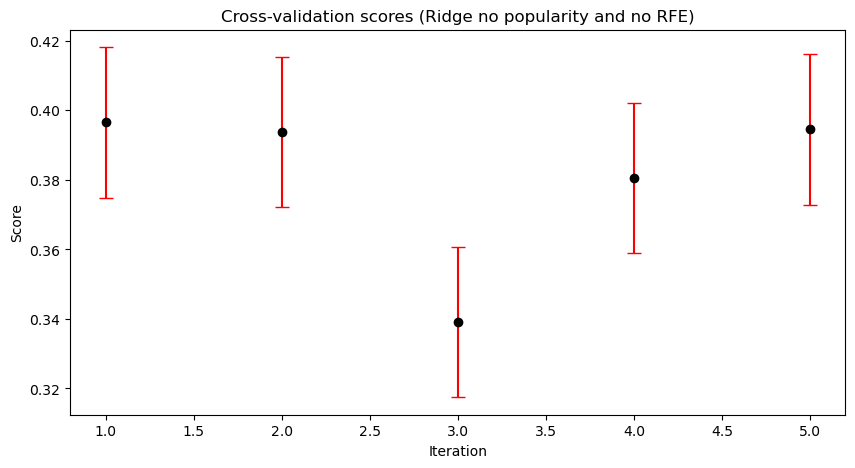

In [70]:
plt.figure(figsize=(10, 5))
plt.errorbar(range(1, 6), scores, yerr=scores.std(), fmt='o', color='black', ecolor='red', capsize=5)
plt.title('Cross-validation scores (Ridge no popularity and no RFE)')
plt.xlabel('Iteration')
plt.ylabel('Score')

# Ridge Regression no Popularity and RFE

In [71]:
model = Ridge(alpha=1.0)

rfe = RFE(estimator=model, n_features_to_select=10)

X_train_rfe = rfe.fit_transform(X_train, y_train)

scores = cross_val_score(model, X_train, y_train, cv=5)

print(f"Cross-validation scores: {scores}")

print(f"Mean cross-validation score: {scores.mean()}")

print(f"Standard Deviation of cross-validation score: {scores.std()}")

model.fit(X_train_rfe, y_train)

selected_features = pd.Series(rfe.support_, index = X_train.columns)
print(selected_features[selected_features==True].index)

X_test_rfe = rfe.transform(X_test)
y_pred = model.predict(X_test_rfe)

print(f"R-squared Score: {r2_score(y_test, y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred)}")

Cross-validation scores: [0.39650672 0.39381732 0.33912734 0.3804766  0.39450336]
Mean cross-validation score: 0.3808862664954177
Standard Deviation of cross-validation score: 0.02163613626265188
Index(['Drama', 'Mystery', 'Shounen', 'Supernatural', 'Seinen', 'Horror',
       'Thriller', 'School', 'Military', 'Dementia'],
      dtype='object')
R-squared Score: 0.21314422922785337
Mean Squared Error: 0.6051006848012599
Mean Absolute Error: 0.6189399219184644


Text(0, 0.5, 'Score')

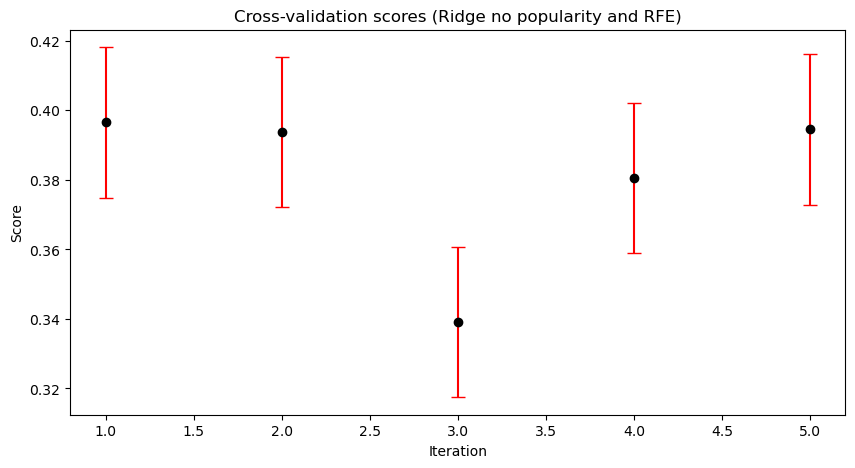

In [72]:
plt.figure(figsize=(10, 5))
plt.errorbar(range(1, 6), scores, yerr=scores.std(), fmt='o', color='black', ecolor='red', capsize=5)
plt.title('Cross-validation scores (Ridge no popularity and RFE)')
plt.xlabel('Iteration')
plt.ylabel('Score')